# 月別ログイン状況

In [101]:
from pathlib import Path
import matplotlib
import math
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import sys
sys.path.append('../../../utility/python/')
from utility import (
    semi_join, anti_join, preprocess_web_logs_screen_name, complement_data,
    sub_days, plus_day, add_group_num, plot_two_axis_bar_line,plus_month
)
from utility import load_web_logs_from_bigquery, load_daily_user_logs_from_bigquery, load_data_from_db_with_script

In [102]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
data_dir_path = Path('data')
result_dir_path = Path('result')
if not data_dir_path.exists():
    data_dir_path.mkdir(parents=True)

データ集計日の指定  
データの加工の際に使うことが多いため

In [104]:
target_day = '2022-11-03'
target_month = target_day[:7]

In [105]:
mazrica_domain_ids = [1, 8, 2095]
privilege_replace_dict = {1: '1_管理職', 2: '2_一般', 3: '2_一般'}
daily_user_logs_name_dict = {
    'deal_board': '案件ボード',
    'deals_table': '案件一覧',
    'actions_table': 'アクション一覧',
    'customers_table': '取引先一覧',
    'contacts_table': 'コンタクト一覧',
    'campaigns_table': 'キャンペーン一覧',
    'webforms_table': 'ウェブフォーム一覧',
    'custom_reports_table': 'カスタムレポート一覧',
    'dashboards_table': 'ダッシュボード一覧',
    'deal_page': '案件ページ',
    'action_page': 'アクションページ',
    'customer_page': '取引先ページ',
    'contact_page': 'コンタクトページ',
    'campaign_page': 'キャンペーンページ',
    'webform_page': 'ウェブフォームページ',
    'custom_report_page': 'カスタムレポートページ',
    'dashboard_page': 'ダッシュボードページ',
    'notification_modal_page': '通知モーダルページ',
    'reports': 'レポート系',
    'customer_merge_candidate': '名寄せ_取引先',
    'contact_merge_candidate': '名寄せ_コンタクト'
}

### データダウンロード

In [106]:
domain_user_maps = pd.read_csv('domain_user_maps.csv')
daily_user_logs = pd.read_csv(data_dir_path.joinpath('daily_user_logs.tsv'), sep='\t')

### 前処理

#### 「domain_user_maps」の前処理

・マツリカユーザー削除  
・契約済みドメインのみを残す  
　・「use_type」が 30 あるいは 40  
・「contract_start_date」を文字列に変換  
　・文字列としておくことで加工がしやすくなる  

In [107]:
domain_user_maps = anti_join(domain_user_maps, pd.DataFrame({'domain_id': mazrica_domain_ids}), by='domain_id')
domain_user_maps = domain_user_maps.query('use_type == 30 or use_type == 40', engine='python').assign(
    contract_start_date=lambda x: x.contract_start_date.astype(str)
)

#### 「daily_user_logs」の前処理

・「date」を文字列変換  
　・文字列としておくことで加工がしやすくなる  
・「domain_user_maps」との結合  
・各ユーザーは「契約開始日」以降のデータだけを残す  
　・契約開始日以前にログインしていることが考えられるため

In [108]:
daily_user_logs = pd.merge(
    daily_user_logs,
    domain_user_maps[['domain_id', 'user_id', 'privilege', 'contract_start_date']],
    on='user_id', how='inner'
).query('date >= contract_start_date', engine='python')

## 月別ログインユーザー数の集計

・変数の間、「,」のあとは基本的には「スペース」を入れる  
　・可読性が上がるため  
・「merge」するさいは、引数「how」を明示したほうが良い  
　・明示しない場合に意図しない結合の仕方になってしまうことがある  

### 月別ログイン数

・グラフのラベル付を行う場合は、変数の値を使うようにする  
　・集計対象日が変わっても自動的に対応するため  
・月のラベルを指定する際は、西暦をつけたほうが良い  
　・資料を見る人にとって誤読しないようにするため  
・データフレームの加工において、キーチェーンでかくとよい  
　・処理を「.」でつなげることで直感的に、労力なくデータの加工ができる

In [109]:
plot_data = daily_user_logs.query('login_web == 1', engine='python').assign(
    month=lambda x: x.date.map(lambda y: dt.datetime.strptime(
        y, '%Y-%m-%d'
    ).strftime('%Y-%m'))
).query(f'month <= "{plus_month(target_day, -1)}"', engine='python').groupby(
    'month'
)['user_id'].nunique().reset_index().rename(columns={'user_id': 'login_uu'}).assign(
    month=lambda x: x.month.map(lambda y: dt.datetime.strptime(y, '%Y-%m').strftime('%Y年%m月'))
)
plot_data

,month,login_uu
0,2022年03月,3019
1,2022年04月,3344
2,2022年05月,3561
3,2022年06月,3819
4,2022年07月,3779
5,2022年08月,3899
6,2022年09月,4021
7,2022年10月,4072


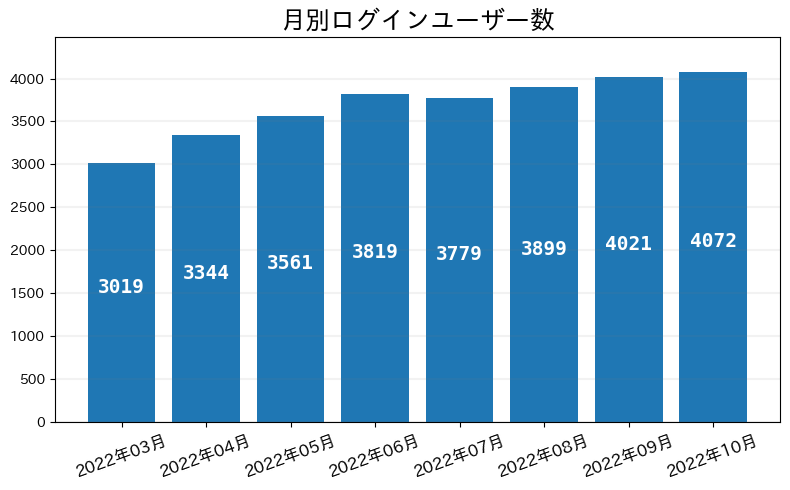

In [110]:
plt.figure(figsize=(8, 5), facecolor='white')
plt.bar(plot_data['month'], plot_data['login_uu'], align="center", width=0.8)
plt.title("月別ログインユーザー数", fontsize=18, weight='bold')
plt.ylim(0, plot_data['login_uu'].max() * 1.1)
plt.xticks(rotation=20, fontsize=12)
for tick in plt.yticks()[0]:
    plt.axhline(tick, color='grey', alpha=0.1)
for i, value in enumerate(plot_data['login_uu']):
    plt.annotate(
        value, (i, value / 2),
        fontsize=14, weight='bold', ha='center',
        color='white', fontfamily='monospace'
    )
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('login_uu_montly_trend.png'), dpi=300)

### 月別ログイン日数でのグループ

グラフのための加工の仕方  
① 「group_by」を使って月別ユーザーごとのログイン日数を求める  
②　「utility.py」の「add_group_num」関数を使ってログイン日数によるグループ番号を付与  
③　月別ログイン日数グループごとのユーザ数を求める  
④　積み上げ棒グラフ用に各月の累積ログイン日数を集計  

In [118]:
plot_data = daily_user_logs.query('login_web == 1', engine='python').assign(
    month=lambda x: x.date.map(lambda y: dt.datetime.strptime(
        y, '%Y-%m-%d'
    ).strftime('%Y-%m'))
).query(f'month <= "{plus_month(target_day, -1)}"', engine='python').groupby(
    ['month', 'user_id']
)['date'].nunique().reset_index().rename(columns={'date': 'n_login_day'})

plot_data = add_group_num(
    data=plot_data,
    col_name='n_login_day',
    group_values=[1, 2, 11, 21, float('Inf')],
    unit='日'
).groupby(['month', 'group_num', 'group_name'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'login_uu'}).assign(
    month=lambda x: x.month.map(lambda y: dt.datetime.strptime(y, '%Y-%m').strftime('%Y年%m月'))
)
plot_data['total_login_uu'] = plot_data.groupby('month')['login_uu'].transform('sum')
plot_data = plot_data.assign(login_rate=lambda x: x.login_uu / x.total_login_uu).sort_values(['month', 'group_num'])
plot_data['accumulated_value'] = plot_data.groupby('month')['login_uu'].transform('cumsum')
plot_data.head(10)


,month,group_num,group_name,login_uu,total_login_uu,login_rate,accumulated_value
0,2022年03月,0,1日,402,3019,0.133157,402
1,2022年03月,1,2 ~ 10日,1399,3019,0.463398,1801
2,2022年03月,2,11 ~ 20日,1133,3019,0.375290,2934
3,2022年03月,3,21日 ~,85,3019,0.028155,3019
4,2022年04月,0,1日,413,3344,0.123505,413
5,2022年04月,1,2 ~ 10日,1530,3344,0.457536,1943
6,2022年04月,2,11 ~ 20日,1203,3344,0.359749,3146
7,2022年04月,3,21日 ~,198,3344,0.059211,3344
8,2022年05月,0,1日,432,3561,0.121314,432
9,2022年05月,1,2 ~ 10日,1747,3561,0.490593,2179


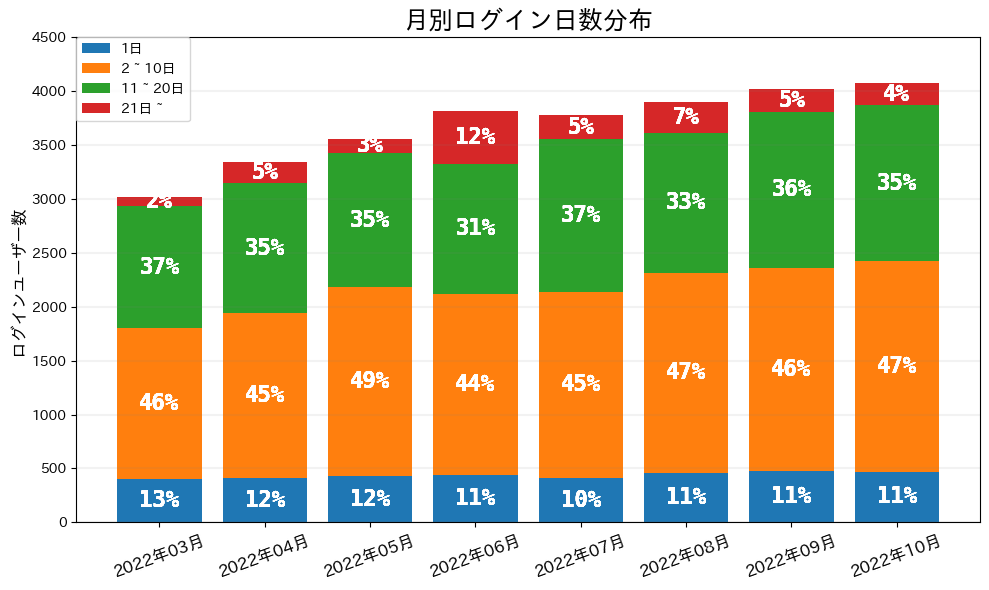

In [119]:

fig = plt.figure(figsize=(10, 6), facecolor='white')
for i, group_name in enumerate(plot_data['group_name'].unique()):
    plot_data_target = plot_data.query(f'group_name == "{group_name}"', engine='python')
    if i == 0:
        plt.bar(plot_data_target['month'], plot_data_target['login_uu'], label=group_name)
    else:
        plt.bar(
            plot_data_target['month'], plot_data_target['login_uu'],
            bottom=plot_data_target['accumulated_value'] - plot_data_target['login_uu'],
            label=group_name
        )
plt.title('月別ログイン日数分布', fontsize=18, weight='bold')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0)
plt.xticks(fontsize=12, rotation=20)
plt.ylabel("ログインユーザー数", fontsize=12)
plt.ylim(0,4500)

for tick in plt.yticks()[0]:
    plt.axhline(tick, color='grey', alpha=0.1)

for group_num in plot_data['group_num']:
    plot_data_target = plot_data.query(f'group_num == {group_num}', engine='python').reset_index(drop=True)
    for i in range(len(plot_data_target)):
        value = plot_data_target.iloc[i]['login_rate']
        y_pozi = plot_data_target.iloc[i]['accumulated_value'] - plot_data_target.iloc[i]['login_uu'] / 2              
        plt.annotate(
            f'{int(value * 100)}%',
            xy=(i, y_pozi), xytext=(i, y_pozi),
            fontweight='bold', fontsize=16, fontfamily='monospace',
            color='white', ha='center', va='center'
        )
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('login_uu_monthly_trend_login_group.png'), dpi=300)